# Part 3, Topic 3: DPA on Firmware Implementation of AES

---
**NOTE: This lab is part of the ChipWhisperer.io training - this lab is not part of the public material on [ChipWhisperer github](https://github.com/newaetech/chipwhisperer-jupyter). Please do not distribute this lab without permission!**

---

In the previous lab, you saw how a single bit of information can be used to recover an entire byte of the AES key. Remember, this works due to the S-Box being present in the data flow that we are attacking.

Next, we'll see how to use power analysis instead of an actual bit value. With this technique, the goal is to separate the traces by a bit in the result of the SBox output (it doesn't matter which one): if that bit is 1, its group of traces should, on average, have higher power consumption during the SBox operation than the other set.

This is all based on the assumption we discussed in the slides and saw in earlier labs: there is some consistent relationship between the value of bits on the data bus and the power consumption in the device.

## AES Model

No need to remember the complex model from before - we can instead just jump right into the AES model! Copy your AES model you developed in the previous lab below & run it:

In [3]:
# ###################
# Add your code here
# ###################

sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

You can verify the model works by running the following blocks, just like last time:

In [4]:
#Simple test vectors - if you get the check-mark printed all OK.
assert(aes_internal(0xAB, 0xEF) == 0x1B)
assert(aes_internal(0x22, 0x01) == 0x26)
print("✔️ OK to continue!")

✔️ OK to continue!


## AES Power Watcher

The power watcher is going to send random data to the device, and observe the power consumption during the encryption.

You can check out the hardware version, which uses a capture loop like this:

    print(scope)
    for i in trange(N, desc='Capturing traces'):
        key, text = ktp.next()  # manual creation of a key, text pair can be substituted here

        trace = cw.capture_trace(scope, target, text, key)
        if trace is None:
            continue
        traces.append(trace)
        plot.send(trace)

    #Convert traces to numpy arrays
    trace_array = np.asarray([trace.wave for trace in traces])
    textin_array = np.asarray([trace.textin for trace in traces])
    known_keys = np.asarray([trace.key for trace in traces])  # for fixed key, these keys are all the same

But luckily I've already run the capture for you (thank me later!). If you run the following block, you'll get the `trace_array` and `textin_array` variables defined in your workspace.

In [5]:
%run "traces/aes_2500traces_random.ipynb"

assert(len(trace_array) == 2500)
print("✔️ OK to continue!")

✔️ OK to continue!


What's this data look like? Try plotting a trace or two here:

<IPython.core.display.Javascript object>


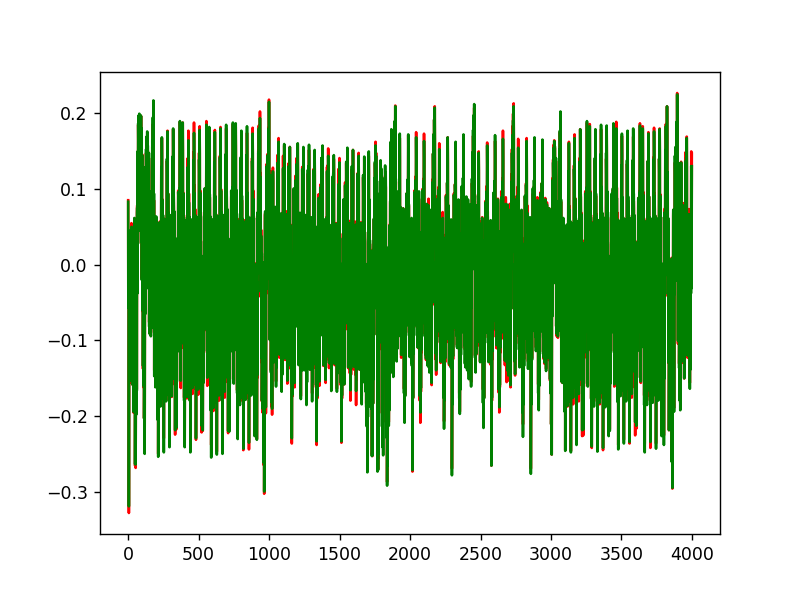

In [6]:
%matplotlib notebook
import matplotlib.pylab as plt
plt.figure()
plt.plot(trace_array[0], 'r')
plt.plot(trace_array[1], 'g')
plt.show()

OK interesting - so we've got data! And what about the format of the input data?

In [7]:
print(textin_array[0])
print(textin_array[1])

[ 94 127  82  73 116 107  66 194 255 200  14  37 136  54 212  26]
[199 241 246  29 133 211 242 230  86  28 114 160  29  35  38 129]


## AES Guesser - One Byte

The attack now needs a way of splitting traces into two groups, depending on the state of a bit in our "guessed" value. We're going to start easy by guessing a single byte of the AES key at a time.

To start with - define the number of traces & number of points in each trace. You can use the following example code, just run this block:

In [8]:
numtraces = np.shape(trace_array)[0] #total number of traces
numpoints = np.shape(trace_array)[1] #samples per trace

If you remember from the slides - our algorithm looks like this:    

    for key_byte_guess_value in [0, 1, 2, 3, ... 253, 254, 255]:
        
        one_list = empty list
        zero_list = empty list
        
        for trace_index in [0, 1, 2, 3, ..., numtraces]:
        
            input_byte = textin_array[trace_index][byte_to_attack]
            
            #Get a hypothetical leakage list - use aes_internal(guess, input_byte)          

            if hypothetical_leakage bit 0 is 1:
                append trace_array[trace_index] to one_list
            else:
                append trace_array[trace_index] to zero_list
                
        one_avg = average of one_list
        zero_avg = average of zero_list

        max_diff_value = maximum of ABS(one_avg - zero_avg)
        
To get the average of your `one_list` and `zero_list` you can use numpy:

    import numpy as np
    avg_one_list = np.asarray(one_list).mean(axis=0)

The important thing here is the `axis=0`, which does an average so the resulting array is done across all traces (not just the average value of one trace, but the average of each point index *across all traces*).

To help you do some testing - let me tell you that the correct value of byte 0 is `0x2B`. You can use this to validate that your solution is working on the first byte. If you get stuck - see some hints below (but give it a try first).

What you should see is an output of the maximum value between the two average groups be higher for the `0x2B` value. For example, priting the maximum SAD value from an example loop looks like this for me:

    Guessing 28: 0.001397
    Guessing 29: 0.000927
    Guessing 2a: 0.001953
    Guessing 2b: 0.005278
    Guessing 2c: 0.000919
    Guessing 2d: 0.002510
    Guessing 2e: 0.001241
    Guessing 2f: 0.001242

Note the value of `0.005278` for `0x2B` - this is higher than the others which range from `0.000927` to `0.002510`.

In [12]:
# ###################
# Add your code here
# ###################

import numpy as np
mean_diffs = np.zeros(256)

guessed_byte = 0

for guess in range(0, 256):
    
    one_list = []
    zero_list = []
    
    for trace_index in range(numtraces):
        
        #Get a hypothetical leakage list - use aes_internal(guess, input_byte)
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])
    
        #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
        if hypothetical_leakage & 0x01:        
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])
            
    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    mean_diffs[guess] = np.max(abs(one_avg - zero_avg))
    
    print("Guessing %02x: %f"%(guess, mean_diffs[guess]))

Guessing 00: 0.001772
Guessing 01: 0.000986
Guessing 02: 0.002144
Guessing 03: 0.001679
Guessing 04: 0.001236
Guessing 05: 0.001354
Guessing 06: 0.001608
Guessing 07: 0.001205
Guessing 08: 0.002144
Guessing 09: 0.001048
Guessing 0a: 0.001752
Guessing 0b: 0.001835
Guessing 0c: 0.001570
Guessing 0d: 0.000994
Guessing 0e: 0.002880
Guessing 0f: 0.000908
Guessing 10: 0.001296
Guessing 11: 0.001021
Guessing 12: 0.001040
Guessing 13: 0.001714
Guessing 14: 0.001992
Guessing 15: 0.001748
Guessing 16: 0.001505
Guessing 17: 0.001251
Guessing 18: 0.001085
Guessing 19: 0.001837
Guessing 1a: 0.001418
Guessing 1b: 0.001443
Guessing 1c: 0.001175
Guessing 1d: 0.000801
Guessing 1e: 0.001502
Guessing 1f: 0.000893
Guessing 20: 0.001343
Guessing 21: 0.000934
Guessing 22: 0.002205
Guessing 23: 0.001595
Guessing 24: 0.001469
Guessing 25: 0.001348
Guessing 26: 0.000947
Guessing 27: 0.001606
Guessing 28: 0.001397
Guessing 29: 0.000927
Guessing 2a: 0.001953
Guessing 2b: 0.005278
Guessing 2c: 0.000919
Guessing 2

### Hint 1: General Program Flow

You can use the following general program flow to help you implement the outer loop above:

In [13]:
#Hint #1 - General Program Flow
import numpy as np
mean_diffs = np.zeros(256)

guessed_byte = 0

for guess in range(0, 256):
    
    one_list = []
    zero_list = []
    
    for trace_index in range(numtraces):
        #Inside here do the steps shown above
        pass
        
    #Do extra steps to average one_list and zero_list        

### Hint 2: Example of Two Guesses

We aren't fully going to give it away (see `SOLN` notebook if you want that), but here is how you can generate two differences, for `0x2B` and `0xFF`. If you're totally stuck you can use the following code to base what should be inside the loops on.

In [15]:
import numpy as np
mean_diffs = np.zeros(256)

### Code to do guess of byte 0 set to 0x2B
guessed_byte = 0
guess = 0x2B
   
one_list = []
zero_list = []
    
for trace_index in range(numtraces):
    hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])

    #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
    if hypothetical_leakage & 0x01:        
        one_list.append(trace_array[trace_index])
    else:
        zero_list.append(trace_array[trace_index])
            
one_avg = np.asarray(one_list).mean(axis=0)
zero_avg = np.asarray(zero_list).mean(axis=0)
mean_diffs_2b = np.max(abs(one_avg - zero_avg))

print("Max SAD for 0x2B: {:1}".format(mean_diffs_2b))

### Code to do guess of byte 0 set to 0xFF
guessed_byte = 0
guess = 0xFF
    
one_list = []
zero_list = []
    
for trace_index in range(numtraces):
    hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])

    #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
    if hypothetical_leakage & 0x01:        
        one_list.append(trace_array[trace_index])
    else:
        zero_list.append(trace_array[trace_index])
            
one_avg = np.asarray(one_list).mean(axis=0)
zero_avg = np.asarray(zero_list).mean(axis=0)
mean_diffs_ff = np.max(abs(one_avg - zero_avg))

print("Max SAD for 0xFF: {:1}".format(mean_diffs_ff))

Max SAD for 0x2B: 0.005278344712242838
Max SAD for 0xFF: 0.002763309921206908


## Ranking Guesses

You'll also want to rank some of your guesses (we assume). This will help you identify the most likely value. The best way to do this is build a list of the maximum difference values for each key:

    mean_diffs = [0]*256

    for key_byte_guess_value in [0, 1, 2, 3, ... 253, 254, 255]:

        *** CODE FROM BEFORE***
        max_diff_value = maximum of ABS(one_avg - zero_avg)
        mean_diffs[key_byte_guess_value] = max_diff_value
        
If you modify your previous code, it will generate a list of maximum differences in a list. This list will look like:

    [0.002921, 0.001923, 0.005131, ..., 0.000984]
    
Where the *index* of the list is the value of the key guess. We can use `np.argsort` which generates a new list showing the *indicies* that would sort an original list (you should have learned about `argsort` in the previous lab too):

So for example, run the following to see it in action on the list `[1.0, 0.2, 3.4, 0.01]`:

In [19]:
np.argsort([1.0, 0.2, 3.4, 0.01])

array([3, 1, 0, 2], dtype=int64)

This should return `[3, 1, 0, 2`] - that is the order of lowest to highest. To change from highest to lowest, remember you just add `[::-1]` at the end of it like `np.argsort([1.0, 0.2, 3.4, 0.01])[::-1]`.

Try using the `np.argsort` function to output the most likely key values from your attack.

## Plotting Differences

Before we move on - you should take a look at various plots of these differences. They will play in something called the *ghost peak* problem.

We're going to now define a function called `calculate_diffs()` that implements our attacks (you can replace this with your own function or keep this one for now):

In [22]:
def calculate_diffs(guess, byteindex=0, bitnum=1):
    """Perform a simple DPA on two traces, uses global `textin_array` and `trace_array` """
    
    one_list = []
    zero_list = []

    for trace_index in range(numtraces):
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][byteindex])

        #Mask off the requested bit
        if hypothetical_leakage & (1<<bitnum):
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])

    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    return abs(one_avg - zero_avg)

Try plotting the difference between various bytes. For byte 0, remember `0x2B` is the correct value. Zoom in on the plots and see how the correct key should have a much larger difference.

Sometimes we get *ghost peaks* which are incorrect peaks. So far we're assuming there is a single "best" solution for the key - we may need to get fancy and put a threshold whereby we have several candidates for the correct key. For now let's just plot a handful of examples:

<IPython.core.display.Javascript object>


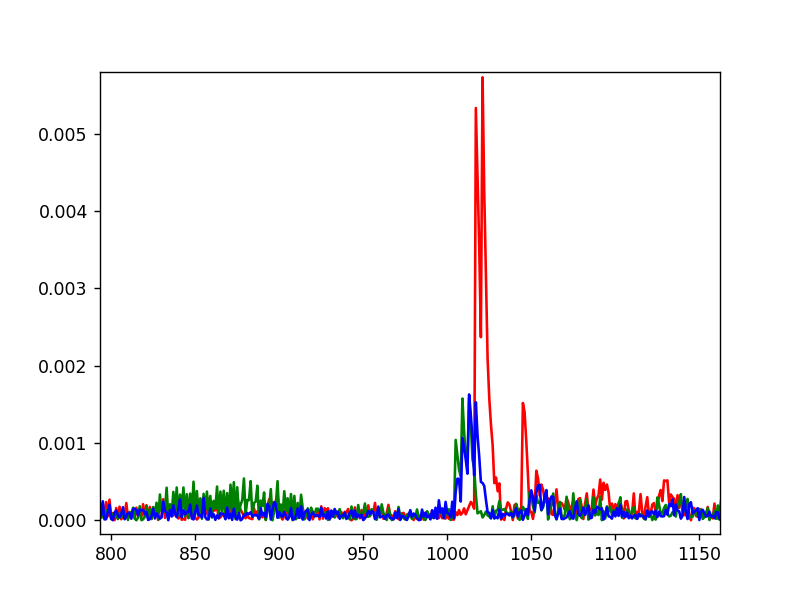

In [29]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.plot(calculate_diffs(0x2B), 'r')
plt.plot(calculate_diffs(0x2C), 'g')
plt.plot(calculate_diffs(0x2D), 'b')

Here is what it should look like:

You'll notice when we rank the bytes we just use the maximum value of any peak. There's lots more you could learn from these graphs, such as the location of the peak, or if there are multiple peaks in the graph. But for now we're just going to keep with the 

## AES Guesser - One Byte

Alright - good job! You've got a single byte and some DPA plots up. Now let's move onward and guess *all* of the bytes.

In [20]:
key_guess = []
guess = np.argsort(mean_diffs)[-1]
key_guess.append(guess)

The next block is the most important. You'll need to "apply" the leakage function - that is for each known input byte, pass it through the `aes_internal(input_data, key_guess)` function. The value of `key_guess` is just integers in `[0x00, 0x01,...,0xFF]` - aka every possible value of the key byte. We'll compare the number of matching bits between our observed (leaked) data bit and the hypothetical data bit.

In [ ]:
for guess in range(0, 256):   
    
    #Get a hypothetical leakage list - use aes_internal(guess, input_byte) and mask off to only get value of lowest bit
    hypothetical_leakage = ???
    
    #Use our function
    same_count = num_same(hypothetical_leakage, leaked_data)   
    
    #Print for debug
    print("Guess {:02X}: {:4d} bits same".format(guess, same_count))

If your key guess is wrong, about half of the guesses should be wrong. Looking through the list, you'll see that most of the "bits same" numbers will be around 500. But scroll down to the correct key value (should be `0xEF` if you haven't changed it earlier). With any luck, that number should be fully correct - 1000 matching bits. This is only possible if the internal "secret key" byte matches the observed key.

Now a handy thing to do will be to sort based on the values by number of correct bits so we don't have to look through that list. An easy way to do this is with `numpy.argsort` - this returns the indicies that would sort the list. To start small, take the following for example:

In [ ]:
import numpy as np

count_list = [2, 7, 24, 4, 5]

np.argsort(count_list)

This should return `[0, 3, 4, 1, 2]` - you can cast the above to `list()` type if you want to get rid of the `array()` type around it.

Inspecting the above, notice that this is the position of each from lowest to highest. We can reverse this to give us a highest to lowest sort instead:

In [ ]:
import numpy as np

count_list = [2, 7, 24, 4, 5]

np.argsort(count_list)[::-1]

Taking your previous code, simply make a new list which contains the number of elements which are the same, where the list index is the *key guess*. As a rough outline, see the following (you'll need to add back in your hypothetical code):

In [ ]:
import numpy as np

guess_list = [0] * 256

for guess in range(0, 256):   
    
    #Get a hypothetical leakage list - use aes_internal(guess, input_byte) and mask off to only get value of lowest bit
    hypothetical_leakage = ???
    
    #Use our function
    same_count = num_same(hypothetical_leakage, leaked_data)   
    
    #Track the number of correct bits
    guess_list[guess] = same_count

#Use np.argsort to generate a list of indicies from low to high, then [::-1] to reverse the list to get high to low.
sorted_list = ???

#Print top 5 only
for guess in sorted_list[0:5]:
        print("Key Guess {:02X} = {:04d} matches".format(guess, guess_list[guess]))

In this case we know that bit '0' was the leakage. What if we didn't know that? Imagine putting our needle down onto the internal bus, but we aren't sure what bit we touched.

Luckily we can easily test that. To do so, we'll need to adjust our leakage function to take in a bit number that is leaking. First, define a function which returns the value of a bit being 1 or 0:

In [ ]:
def get_bit(data, bit):
    ????

In [ ]:
assert(get_bit(0xAA, 7) == 1)
assert(get_bit(0xAA, 0) == 0)
assert(get_bit(0x00, 7) == 0)
print("✔️ OK to continue!")

Now let's make a slightly fancier leakage function with it:

In [ ]:
def aes_leakage_guess(keyguess, inputdata, bit):
    return get_bit(aes_internal(keyguess, inputdata), bit)

In [ ]:
assert(aes_leakage_guess(0xAB, 0x22, 4) == 0)
assert(aes_leakage_guess(0xAB, 0x22, 3) == 0)
assert(aes_leakage_guess(0xAB, 0x22, 2) == 1)
assert(aes_leakage_guess(0xAB, 0x22, 1) == 1)
assert(aes_leakage_guess(0xAB, 0x22, 0) == 1)
print("✔️ OK to continue!")

Finally, finish off this loop by adding your leakage function into it. Running the loop should print results for each bit option - hopefully you see that only the matching bit shows the full number of matches. If you want to try a different leaky bit, you'll then need to go back up to the actual secret observation to make the leak happen from a different bit. But you can see the following code makes no assumptions about 'bit 0' being the leaky one - it will work with any other bit leaking now.

In [ ]:
for bit_guess in range(0, 8):
    guess_list = [0] * 256
    print("Checking bit {:d}".format(bit_guess))
    for guess in range(0, 256):

        #Get a hypothetical leakage for guessed bit (ensure returns 1/0 only)
        #Use bit_guess as the bit number, guess as the key guess, and data from input_data
        hypothetical_leakage = ???

        #Use our function
        same_count = num_same(hypothetical_leakage, leaked_data)   

        #Track the number of correct bits
        guess_list[guess] = same_count

    sorted_list = np.argsort(guess_list)[::-1]

    #Print top 5 only
    for guess in sorted_list[0:5]:
            print("Key Guess {:02X} = {:04d} matches".format(guess, guess_list[guess]))

🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳
Congrats - you did it!!!!

This all assumed you get some way to observe the value of the bit - in our next act, we'll see how power analysis gives us the ability to observe a given bit.

---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2020. ChipWhisperer is a trademark of NewAE Technology Inc., registered in the United States of America, European Union, and Peoples Republic of China.

The special commercial versions of these tutorials you are using here contain similar information to open-source ones we publicly release, but these are tuned to work with our training videos. Public open-source material that can be freely used is in the ChipWhisperer github repository, which can be distributed according to terms of the open-source license it has been released under.

Tutorials derived from our open-source work must be released under the associated open-source license. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community tutorials which we cannot license under special terms and **must** be maintained as an open-source release.</small>